In [1]:
from __future__ import division
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
from timeit import default_timer
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
import random
import argparse
from tqdm import tqdm
import librosa
from torchvision.models import densenet121
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [2]:
!nvidia-smi

Sat Aug  3 13:53:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:08:00.0  On |                  N/A |
|  0%   52C    P8              43W / 250W |   2005MiB / 24576MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
EPOCHS = 20
SEED = 2024
BATCH_SIZE = 32
TEST_SPLIT_RATIO = 0.25
N_FFT = 256
HOP_LEN = 256 // 6
AUGM = False # Augmentation
# Creating the results directory
if not os.path.exists('results'):
    os.makedirs('results')
RESULTS_FILENAME = "./results/inrun_results" # _x.csv
VALID_RESULTS_FILENAME = "./results/valid_results" # _x.csv
TRAIN_RESULTS_FILENAME = "./results/train_results" # _x.csv
BEST_MODEL_FILENAME = "./results/best-model" # _x.pt
EVAL_FREQ=4
NUM_SIMS = 5

In [4]:
TRAIN_DATASET = "../data/train_whales.csv"
TEST_DATASET = "../data/test_whales.csv"

In [5]:
# Fixing the seeds
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

print(f"Cuda is available: {torch.cuda.is_available()}")
dev_names = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
print(f"Device: {dev_names}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Cuda is available: True
Device: ['NVIDIA GeForce RTX 3090']


In [6]:
target_names = ["no-whale","whale"]
target_names_dict = {target_names[i]: i for i in range(len(target_names))}

# Loading the data

In [7]:
t_s = default_timer()
data_train = pd.read_csv(TRAIN_DATASET,sep=",")
columns = data_train.columns
data_train[columns[-1]]=data_train[columns[-1]].replace(target_names_dict)
data_train = data_train.values
data_train_labels = data_train[:,-1].reshape(-1)
data_train_labels = data_train_labels.astype(int)
data_train = data_train[:,:-1]

data_test = pd.read_csv(TEST_DATASET,sep=",")
data_test[columns[-1]]=data_test[columns[-1]].replace(target_names_dict)
data_test = data_test.values
data_test_labels = data_test[:,-1].reshape(-1)
data_test_labels = data_test_labels.astype(int)
data_test = data_test[:,:-1]
t_e = default_timer()

print(f"Data loading - Elapsed time: {t_e-t_s:.2f}s")

Data loading - Elapsed time: 8.89s


In [8]:
data_train.shape, data_test.shape

((10316, 4000), (2580, 4000))

In [9]:
print(data_train.shape)

X_train, X_valid, y_train, y_valid = train_test_split(data_train, data_train_labels, stratify = data_train_labels, test_size = TEST_SPLIT_RATIO, random_state = SEED)   
X_test, y_test = data_test, data_test_labels


(10316, 4000)


In [10]:
len(X_train), len(X_valid), len(X_test), len(y_train), len(y_valid), len(y_test)

(7737, 2579, 2580, 7737, 2579, 2580)

In [11]:
# balance
y_train.sum(), len(y_train) - y_train.sum()

(3869, 3868)

In [12]:
y_valid.sum(), len(y_valid) - y_valid.sum()

(1289, 1290)

In [13]:
y_test.sum(), len(y_test) - y_test.sum()

(1290, 1290)

In [14]:
def random_data_shift(data, u=1.0):
    if np.random.random() < u:
        shift = int(round(np.random.uniform(-len(data)*0.25, len(data)*0.25)))
        data = np.roll(data, shift)
    return data

In [15]:
test = np.arange(20)
print(test.shape, test)
test_out = random_data_shift(test)
print(test_out.shape,test_out)

(20,) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
(20,) [18 19  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [16]:
class AugmentedSTFTDataset(Dataset):
    def __init__(self, inputs, targets, n_fft, hop_length, augment=False):
        self.inputs = inputs
        self.targets = targets
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.augment = augment

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
        sample = self.inputs[idx]
        
        if self.augment:
            sample = random_data_shift(sample)
            
        data = librosa.stft(sample, n_fft=self.n_fft, hop_length=self.hop_length)
        data = librosa.amplitude_to_db(np.abs(data), ref=np.max)
        data = np.flipud(data)  # Flip vertically
        data = data.copy()  
        data = np.expand_dims(data, axis=-1)  # Add channel dimension
        data = np.transpose(data, (2, 0, 1))  # Reorder dimensions to match PyTorch expectations
        return torch.FloatTensor(data), torch.LongTensor([self.targets[idx]])

# Data loader
def create_dataloader(inputs, targets, batch_size, n_fft, hop_length, shuffle=True, augment=False):
    dataset = AugmentedSTFTDataset(inputs, targets, n_fft, hop_length, augment=augment)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

In [17]:
train_loader = create_dataloader(X_train, y_train, BATCH_SIZE, N_FFT, HOP_LEN, shuffle=True, augment=AUGM)
valid_loader = create_dataloader(X_valid, y_valid, BATCH_SIZE, N_FFT, HOP_LEN, shuffle=False, augment=False) 
test_loader = create_dataloader(X_test, y_test, BATCH_SIZE, N_FFT, HOP_LEN, shuffle=False, augment=False) 


In [18]:
EVAL_FREQ = len(train_loader)//EVAL_FREQ

In [19]:
print(len(train_loader), EVAL_FREQ)

242 60


In [20]:
for x, y in train_loader:
    break
print(x.shape,y.shape)

torch.Size([32, 1, 129, 96]) torch.Size([32, 1])


In [21]:
for x, y in valid_loader:
    break
print(x.shape,y.shape)

torch.Size([32, 1, 129, 96]) torch.Size([32, 1])


# Model

In [22]:
class Densenet121(nn.Module):
    def __init__(self):
        super().__init__()
        self.densenet121 = densenet121().features
        self.densenet121.conv0 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.classifier = torch.nn.Linear(1024, 1)
        
    def forward(self, x):
        out = self.densenet121.forward(x)
        out = torch.nn.functional.avg_pool2d(out, kernel_size = out.shape[2:], stride= out.shape[2:], padding=0, count_include_pad = False)
        out = self.classifier(out.view(out.shape[0], -1))
        return out

In [23]:
model = Densenet121()
#model.to(device)

# Utilities

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [25]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0.0
    epoch_acc = 0.0

    model.eval()
    number_of_elements = 0
    
    correct_pred = torch.zeros(2)
    total_pred = torch.zeros(2)


    with torch.no_grad():
        
        y_true = []
        y_pred = []
        for x, y in iterator:

            x = x.to(device)
            y = y.float().to(device).view(-1,1)
            
            batch_size = x.shape[0]
            number_of_elements += batch_size
            
            pred = model(x).view(-1,1)
            loss = criterion(pred, y)
            
            top_pred = (torch.sigmoid(pred) > 0.5).int()
            acc = top_pred.eq(y.int().view_as(top_pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            y_true.append(y.int().cpu().numpy())
            y_pred.append(top_pred.cpu().numpy())
            
        y_true_a = np.concatenate(y_true, axis=0)
        y_pred_a = np.concatenate(y_pred, axis=0)
                        
        #balanced_acc = balanced_accuracy_score(y_true_a, y_pred_a)
        acc = accuracy_score(y_true_a, y_pred_a)

    return epoch_loss / number_of_elements, acc

# Evaluation

## Accuracies and losses



In [26]:
epoch_df = pd.read_csv(f"{VALID_RESULTS_FILENAME}_{0}.csv",sep=";")
epoch_df = epoch_df.drop_duplicates(subset=['epoch'], keep='first')
epoch_df = epoch_df.drop(["valid_loss","valid_acc"], axis=1)
epoch_df["epoch"] = epoch_df["epoch"].astype(str)
df_new = epoch_df.set_index("epoch")
for i in range(5):
    df_valid = pd.read_csv(f"{VALID_RESULTS_FILENAME}_{i}.csv",sep=";")
    df_valid = df_valid.rename(columns={"valid_loss":f"valid_loss_{i}","valid_acc":f"valid_acc_{i}"})
    df_valid["epoch"] = df_valid["epoch"].astype(str)
    df_valid = df_valid.drop_duplicates(subset=['epoch'], keep='first')
    df_valid = df_valid.set_index("epoch")
    df_new = df_new.join(df_valid)


In [27]:
df_new = df_new.reset_index()
df_new["epoch"] = df_new["epoch"].astype(float)

df_new["valid_loss_max"]=df_new[[f"valid_loss_{i}" for i in range(5)]].max(axis=1)
df_new["valid_loss_min"]=df_new[[f"valid_loss_{i}" for i in range(5)]].min(axis=1)
df_new["valid_loss_mean"]=df_new[[f"valid_loss_{i}" for i in range(5)]].mean(axis=1)

df_new["valid_acc_max"]=df_new[[f"valid_acc_{i}" for i in range(5)]].max(axis=1)
df_new["valid_acc_min"]=df_new[[f"valid_acc_{i}" for i in range(5)]].min(axis=1)
df_new["valid_acc_mean"]=df_new[[f"valid_acc_{i}" for i in range(5)]].mean(axis=1)

In [28]:
df_new

,epoch,valid_loss_0,valid_acc_0,valid_loss_1,valid_acc_1,valid_loss_2,valid_acc_2,valid_loss_3,valid_acc_3,valid_loss_4,valid_acc_4,valid_loss_max,valid_loss_min,valid_loss_mean,valid_acc_max,valid_acc_min,valid_acc_mean
0,0.247934,0.473422,78.945328,0.442019,79.294300,0.443633,80.573866,0.453783,77.859636,0.547608,75.106630,0.547608,0.442019,0.472093,80.573866,75.106630,78.355952
1,0.495868,0.413996,81.465684,0.425203,81.155487,0.436581,80.069794,0.419087,80.108569,0.468258,79.177976,0.468258,0.413996,0.432625,81.465684,79.177976,80.395502
2,0.743802,0.515463,74.292361,0.388392,82.318728,0.487541,79.333075,0.420082,83.326871,0.435157,80.651415,0.515463,0.388392,0.449327,83.326871,74.292361,79.984490
3,0.991736,0.358603,85.459480,0.341259,84.994184,0.392083,82.435052,0.313904,86.739046,0.406197,79.798371,0.406197,0.313904,0.362409,86.739046,79.798371,83.885227
4,1.000000,0.360699,84.683986,0.335181,84.955409,0.391529,83.055448,0.342788,85.769678,0.341674,84.761535,0.391529,0.335181,0.354374,85.769678,83.055448,84.645211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,19.247934,0.326965,91.469562,0.341152,91.430787,0.341650,91.585886,0.364220,91.314463,0.373792,91.236914,0.373792,0.326965,0.349556,91.585886,91.236914,91.407522
96,19.495868,0.336388,91.779760,0.352219,91.430787,0.349853,91.663435,0.373300,91.430787,0.379369,91.663435,0.379369,0.336388,0.358226,91.779760,91.430787,91.593641
97,19.743802,0.342366,91.624661,0.365218,91.547111,0.356734,91.547111,0.374368,91.159364,0.389794,91.624661,0.389794,0.342366,0.365696,91.624661,91.159364,91.500582
98,19.991736,0.352098,91.934858,0.372643,91.430787,0.365943,91.314463,0.381551,91.275688,0.399083,91.740985,0.399083,0.352098,0.374264,91.934858,91.275688,91.539356


In [29]:
EPOCHS = np.max(df_new["epoch"].values).astype(int)
epochs_train = np.arange(1,EPOCHS+1)
df_new_train = pd.DataFrame({"epoch":epochs_train})
df_new_train = df_new_train.set_index("epoch")

for i in range(5):
    df_train = pd.read_csv(f"{TRAIN_RESULTS_FILENAME}_{i}.csv",sep=";")
    df_train = df_train.rename(columns={"train_loss":f"train_loss_{i}","train_acc":f"train_acc_{i}"})
    
    df_train = df_train.set_index("epoch")
    df_new_train = df_new_train.join(df_train)

df_new_train["train_loss_max"]=df_new_train[[f"train_loss_{i}" for i in range(5)]].max(axis=1)
df_new_train["train_loss_min"]=df_new_train[[f"train_loss_{i}" for i in range(5)]].min(axis=1)
df_new_train["train_loss_mean"]=df_new_train[[f"train_loss_{i}" for i in range(5)]].mean(axis=1)

df_new_train["train_acc_max"]=df_new_train[[f"train_acc_{i}" for i in range(5)]].max(axis=1)
df_new_train["train_acc_min"]=df_new_train[[f"train_acc_{i}" for i in range(5)]].min(axis=1)
df_new_train["train_acc_mean"]=df_new_train[[f"train_acc_{i}" for i in range(5)]].mean(axis=1)
df_new_train = df_new_train.reset_index()

In [30]:
df_new_train

,epoch,train_loss_0,train_acc_0,train_loss_1,train_acc_1,train_loss_2,train_acc_2,train_loss_3,train_acc_3,train_loss_4,train_acc_4,train_loss_max,train_loss_min,train_loss_mean,train_acc_max,train_acc_min,train_acc_mean
0,1,0.322115,86.480548,0.303046,87.165568,0.364669,84.373788,0.318333,86.842445,0.311390,87.152643,0.364669,0.303046,0.323911,87.165568,84.373788,86.402999
1,2,0.226937,90.358020,0.270663,89.336952,0.242832,89.660075,0.220042,91.159364,0.275837,89.853949,0.275837,0.220042,0.247262,91.159364,89.336952,90.073672
2,3,0.239336,90.448494,0.229444,91.223989,0.365165,84.205765,0.360200,89.401577,0.198129,91.740985,0.365165,0.198129,0.278455,91.740985,84.205765,89.404162
3,4,0.243020,90.538969,0.214431,90.952566,0.281089,88.561458,0.288939,90.836241,0.216850,91.068890,0.288939,0.214431,0.248866,91.068890,88.561458,90.391625
4,5,0.217392,91.534186,0.188712,92.400155,0.230674,91.469562,0.231475,90.228771,0.266012,89.246478,0.266012,0.188712,0.226853,92.400155,89.246478,90.975830
5,6,0.173316,92.917151,0.193885,91.547111,0.220228,90.448494,0.199825,91.663435,0.170594,92.826677,0.220228,0.170594,0.191569,92.917151,90.448494,91.880574
6,7,0.171993,92.800827,0.176700,92.387230,0.189601,92.451855,0.165158,93.020551,0.167523,93.291974,0.189601,0.165158,0.174195,93.291974,92.387230,92.790487
7,8,0.173728,92.787902,0.178308,92.710353,0.164730,92.981776,0.173412,92.154582,0.163126,93.330748,0.178308,0.163126,0.170661,93.330748,92.154582,92.793072
8,9,0.169288,93.537547,0.168804,92.787902,0.159743,93.718496,0.152886,93.447073,0.153907,93.421223,0.169288,0.152886,0.160926,93.718496,92.787902,93.382448
9,10,0.166716,92.762052,0.137733,94.287191,0.173603,92.400155,0.151700,93.951144,0.150054,93.421223,0.173603,0.137733,0.155961,94.287191,92.400155,93.364353


In [31]:
# Adjust font sizes and styles
SMALL_SIZE = 80
MEDIUM_SIZE = 40
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=0)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=0)  # legend fontsize
plt.rc('figure', titlesize=0)  # fontsize of the figure title

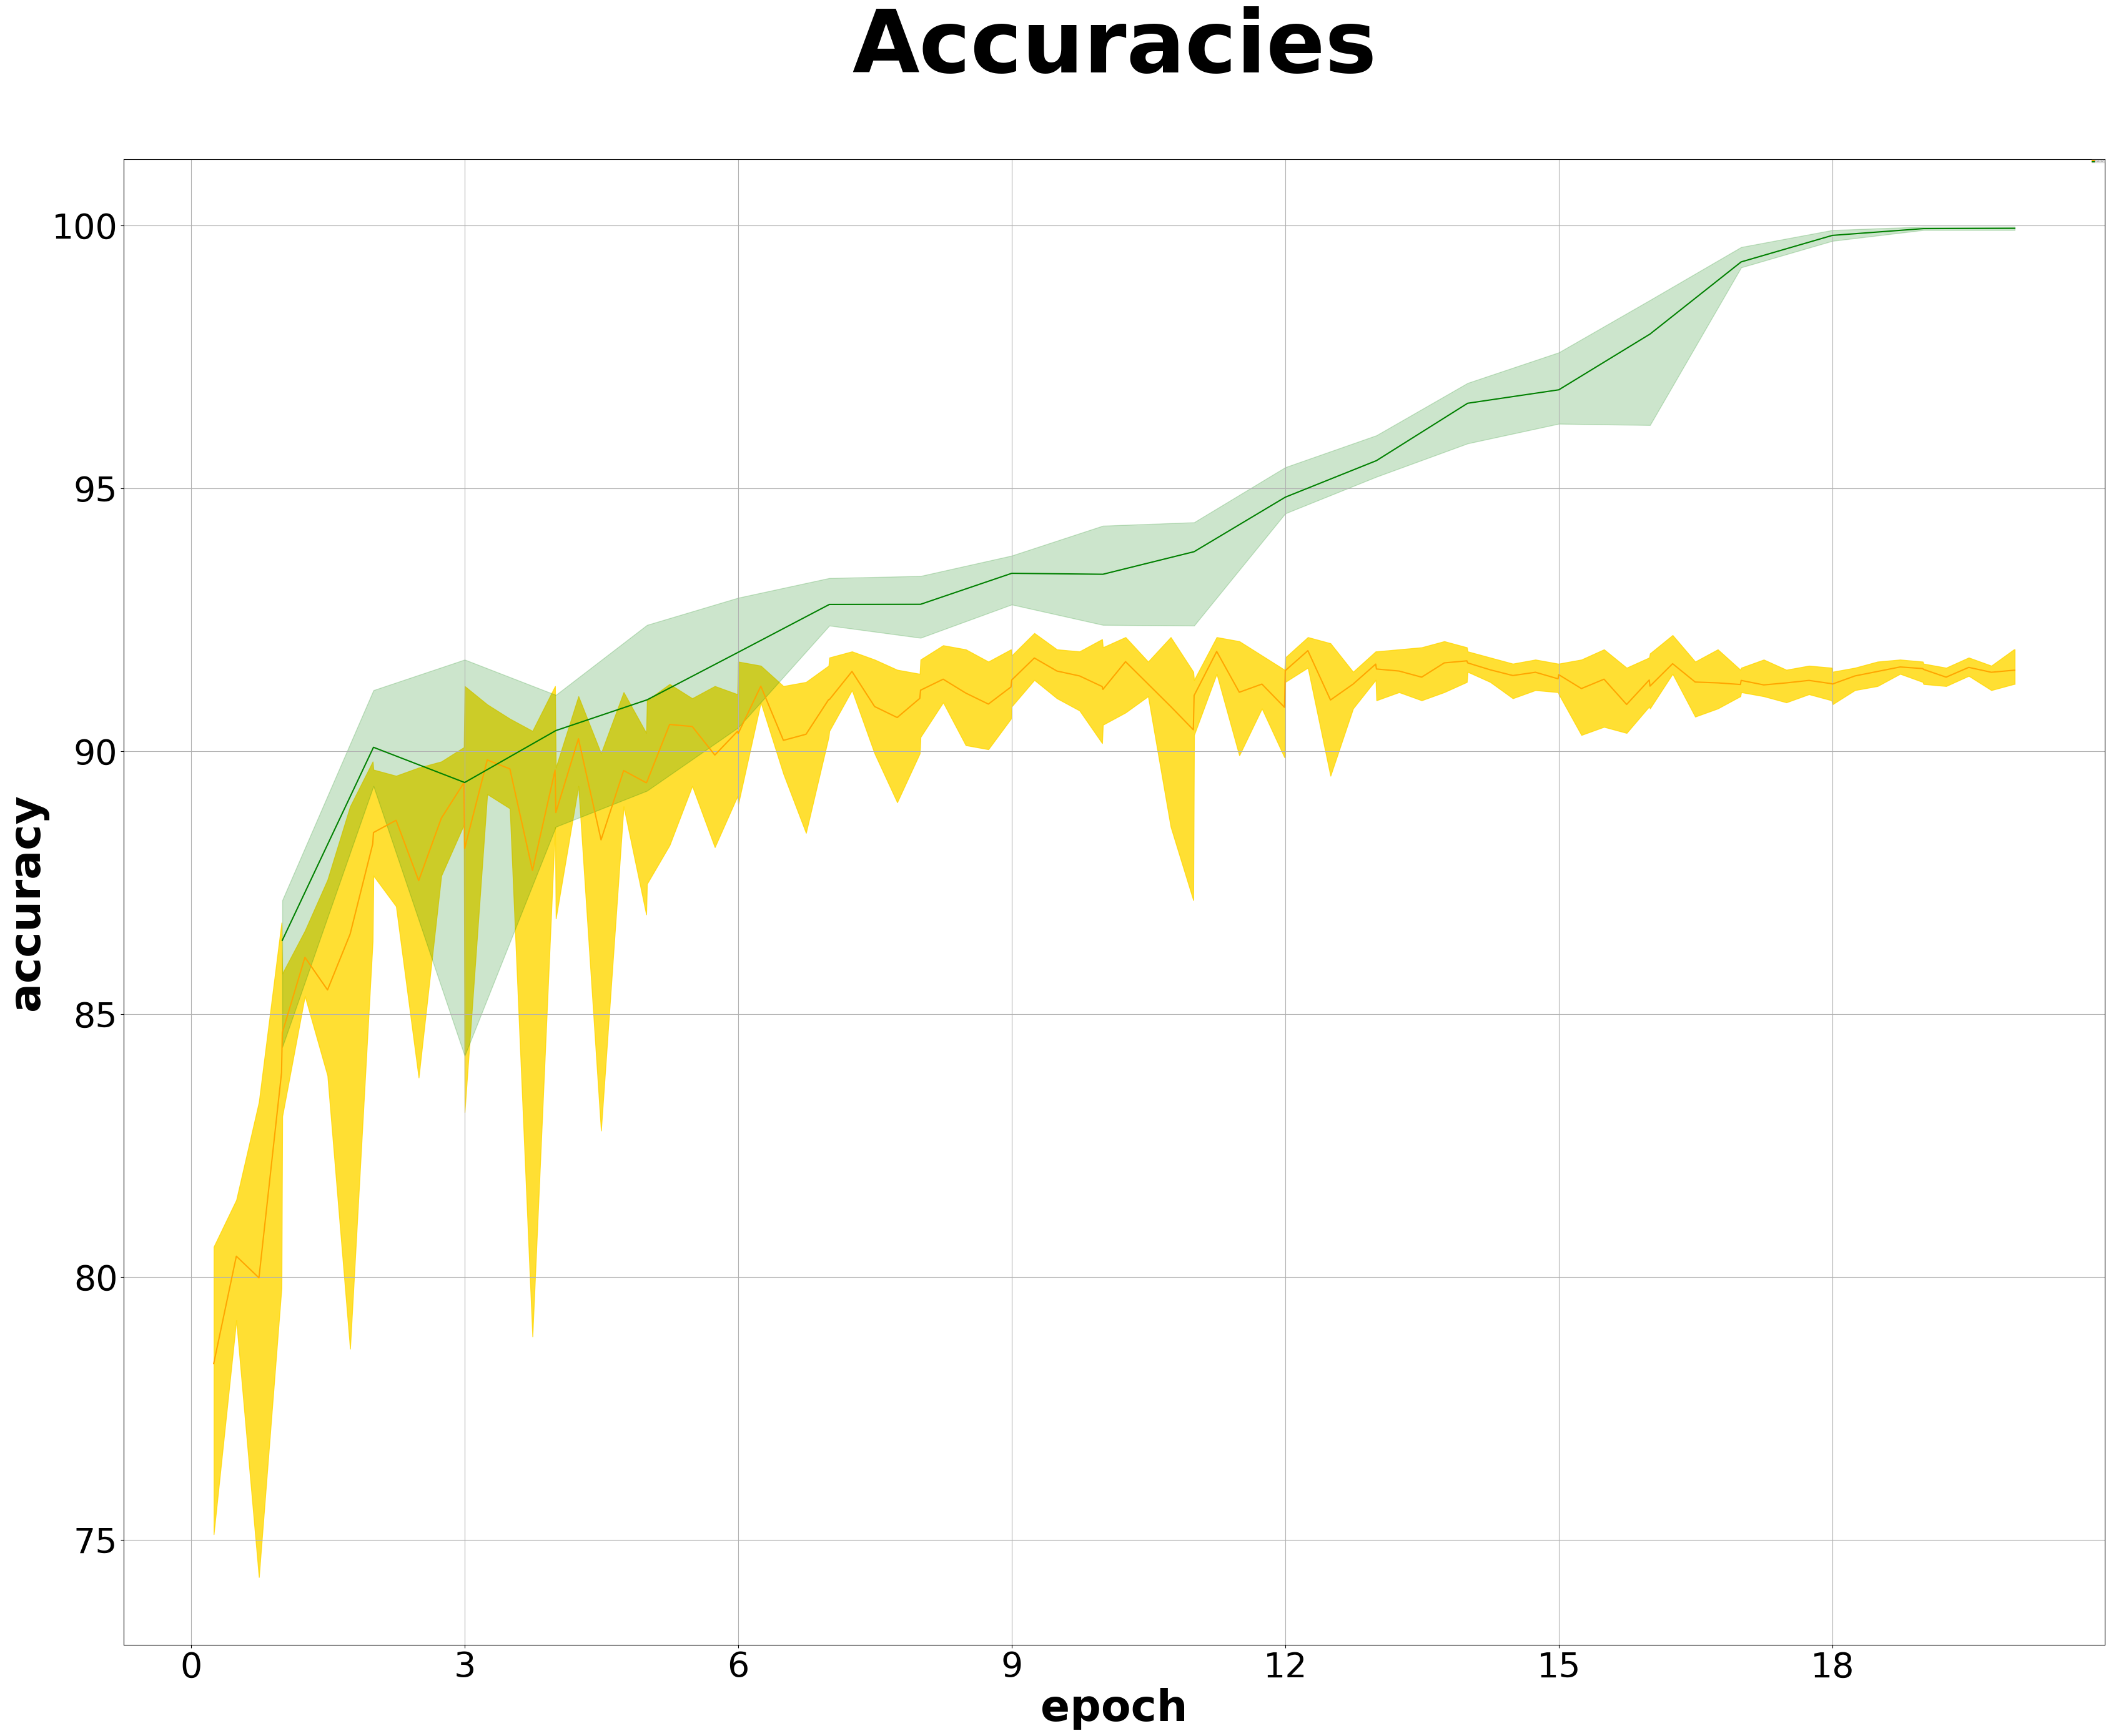

In [32]:
# Accuracies
fig, ax = plt.subplots(figsize=(36,30))
plot_exp = ax.plot(df_new["epoch"], df_new["valid_acc_mean"], 'orange',label="Validation accuracies")
ax.fill_between(df_new["epoch"], df_new["valid_acc_min"],df_new["valid_acc_max"], color='gold', alpha=0.8)
plot_exp = ax.plot(df_new_train["epoch"], df_new_train["train_acc_mean"], 'g-',label="Training accuracies")
ax.fill_between(df_new_train["epoch"], df_new_train["train_acc_min"],df_new_train["train_acc_max"], color='g', alpha=0.2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("epoch",weight="bold",fontsize=50)
plt.ylabel("accuracy",weight="bold",fontsize=50)
plt.legend()
plt.grid()
plt.title(f"Accuracies",fontsize=100,weight="bold",pad=100)
plt.tight_layout()  # Adjust layout to have space between the title and the figure
plt.show(block=False)
fig.savefig('densenet_acc.svg', format='svg')



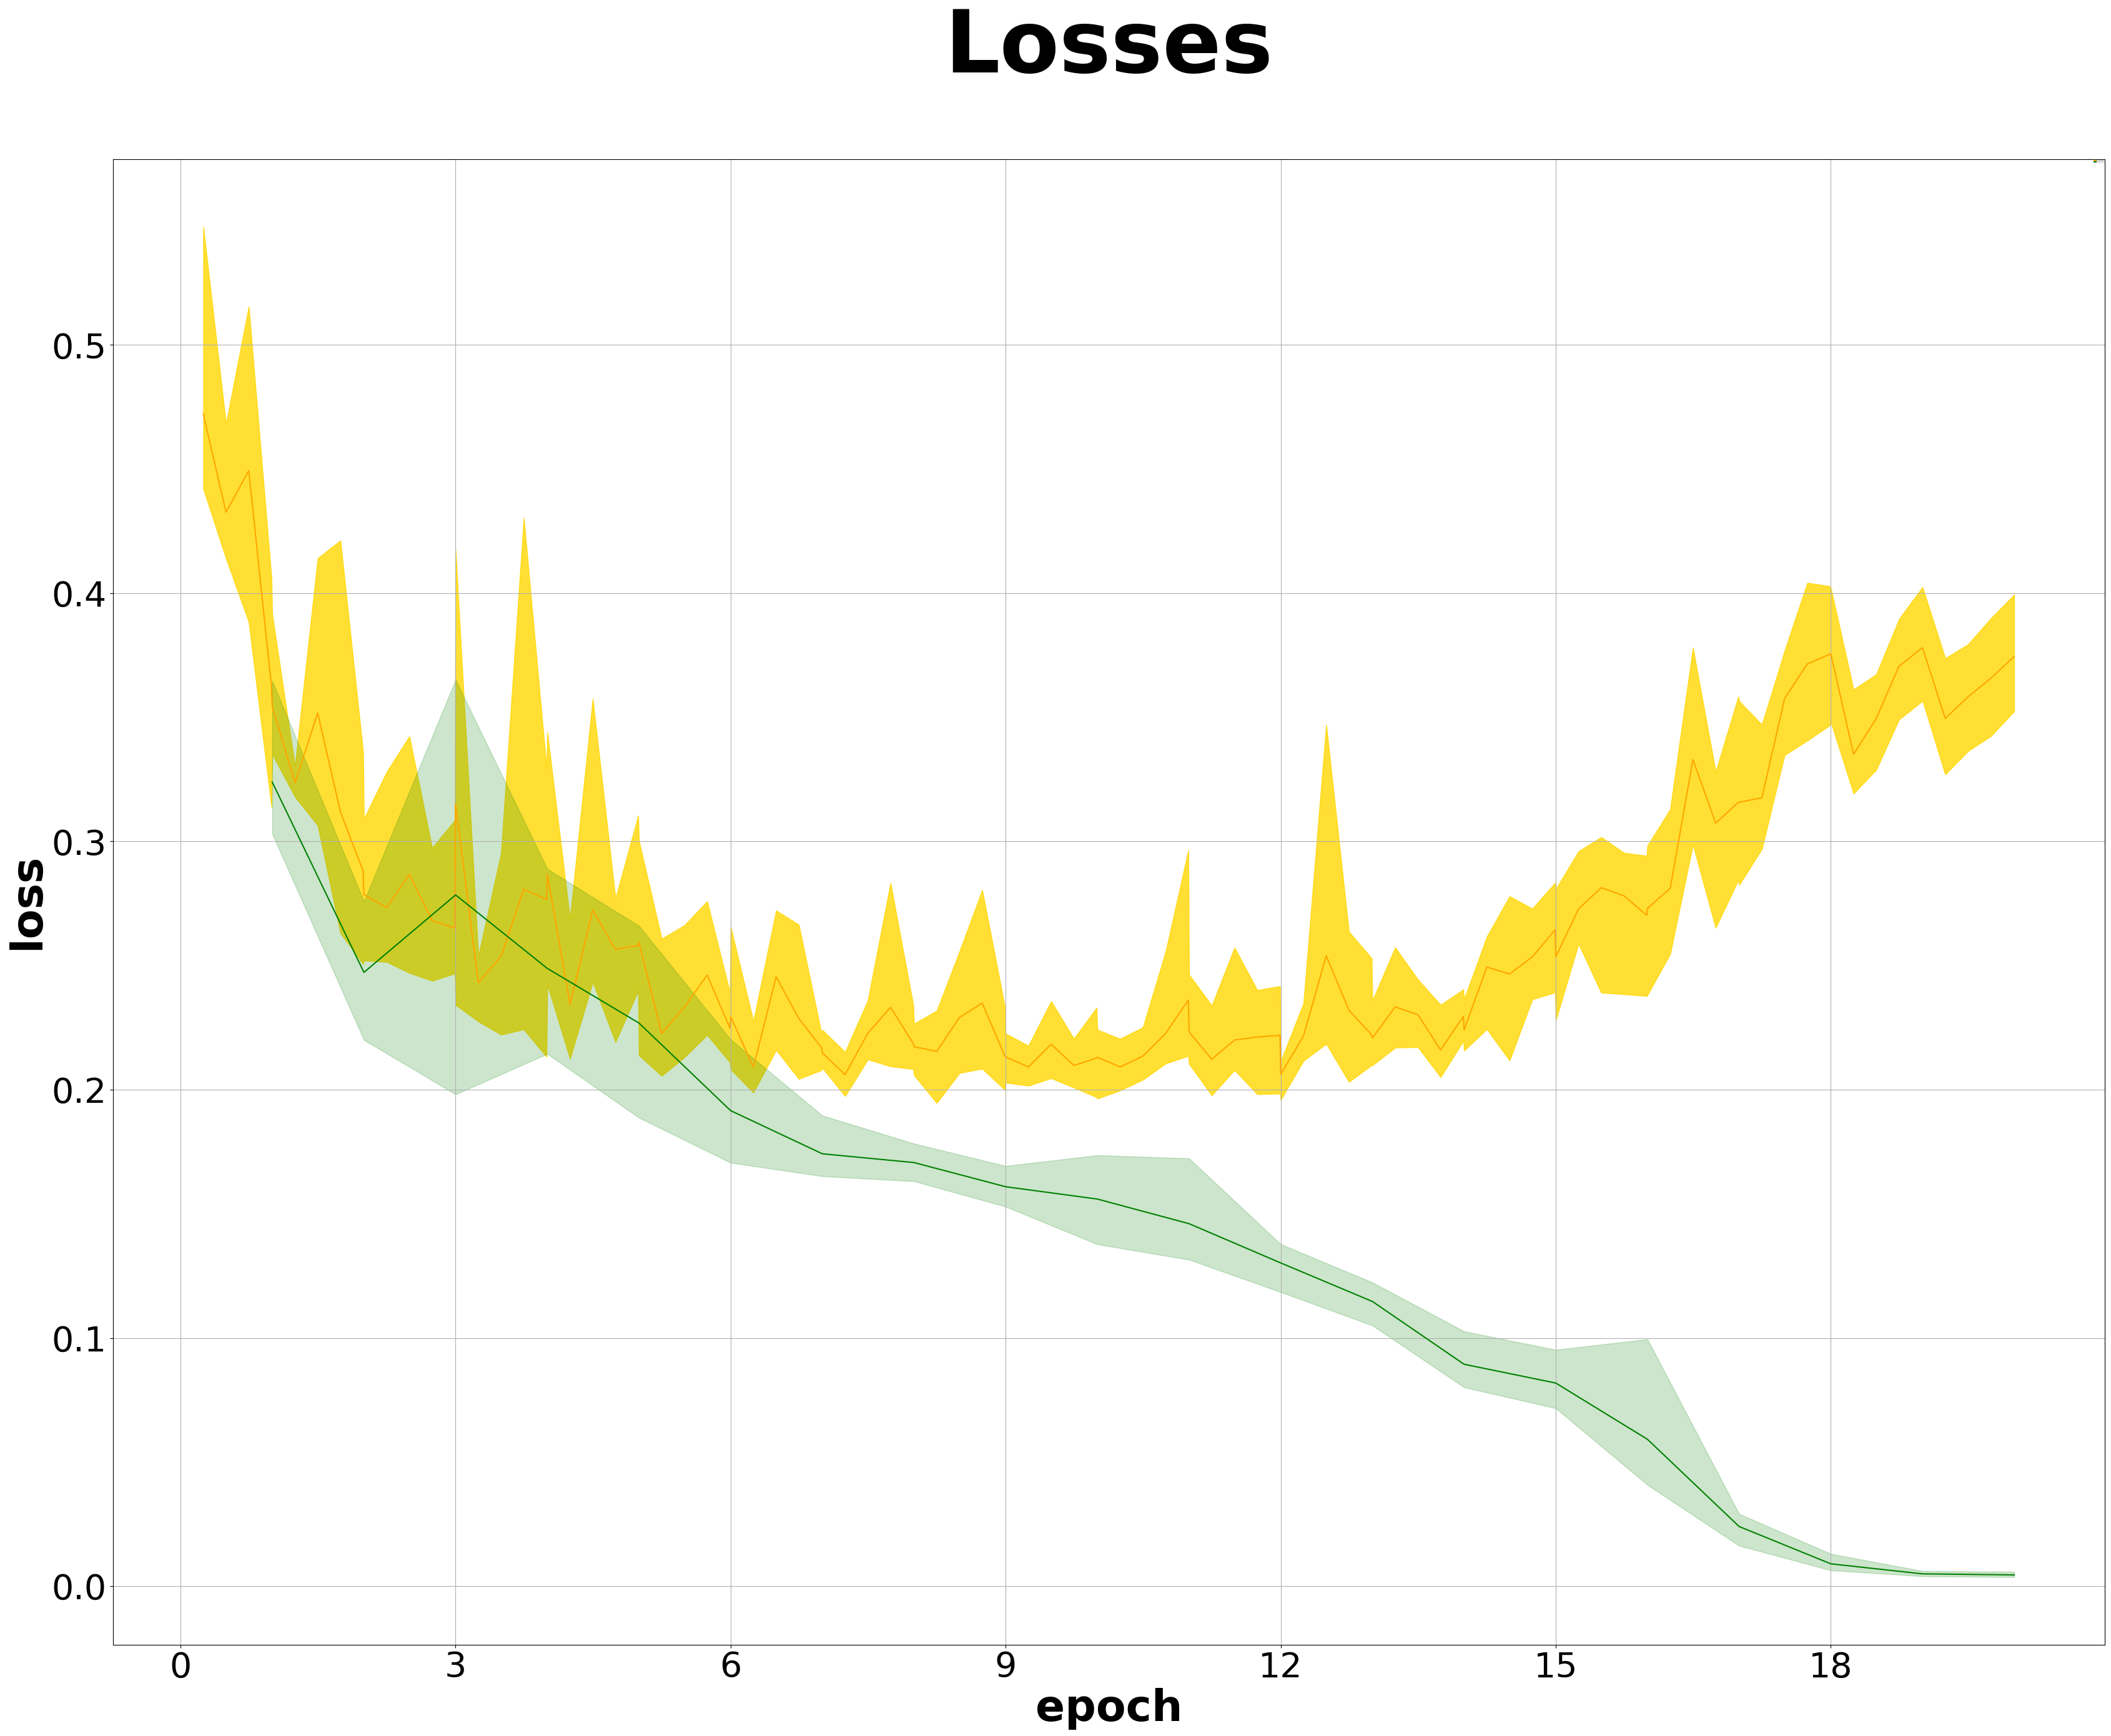

In [33]:
# Losses
fig, ax = plt.subplots(figsize=(36,30))
plot_exp = ax.plot(df_new["epoch"], df_new["valid_loss_mean"], 'orange',label="Validation losses")
ax.fill_between(df_new["epoch"], df_new["valid_loss_min"],df_new["valid_loss_max"], color='gold', alpha=0.8)
plot_exp = ax.plot(df_new_train["epoch"], df_new_train["train_loss_mean"], 'g-',label="Training losses")
ax.fill_between(df_new_train["epoch"], df_new_train["train_loss_min"],df_new_train["train_loss_max"], color='g', alpha=0.2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("epoch",weight="bold",fontsize=50)
plt.ylabel("loss",weight="bold",fontsize=50)
plt.legend()
plt.grid()
plt.title(f"Losses",fontsize=100,weight="bold",pad=100)
plt.tight_layout()  # Adjust layout to have space between the title and the figure
plt.show(block=False)
fig.savefig('densenet_losses.svg', format='svg')

## The best model

In [34]:
# The model with the best validation accuracy
IND = np.argmax(df_new[[f"valid_acc_{i}" for i in range(5)]].max(axis=0).values)
IND

4

In [35]:
state_dict = torch.load(f"{BEST_MODEL_FILENAME}_{IND}.pt")

In [36]:
model = Densenet121()

In [37]:
model.load_state_dict(state_dict)
model.to(device)
print(f"Number of the parameters: {count_parameters(model)}\n")
criterion = torch.nn.BCEWithLogitsLoss(reduction="sum").to(device)

train_loss, train_acc = evaluate(model, train_loader, criterion, device)
valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(160*"-"+"\n")
print(f"The model with the best validation accuracy:")
print(f'Train Loss: {train_loss:.3f} -  Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} - Valid Acc: {valid_acc*100:.2f}% | Test Loss: {test_loss:.3f} - Test Acc: {test_acc*100:.2f}% \t\n')

Number of the parameters: 6948609

----------------------------------------------------------------------------------------------------------------------------------------------------------------

The model with the best validation accuracy:
Train Loss: 0.127 -  Train Acc: 94.73% | Valid Loss: 0.209 - Valid Acc: 92.25% | Test Loss: 0.201 - Test Acc: 91.98% 	



In [38]:
y_preds = []
y_true = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        y_true.append(y.view(-1,1))

        x = x.to(device)
        y = y.to(device)
                
        y_pred = model(x)
            
        top_pred = (torch.sigmoid(y_pred) > 0.5).int()
        y_preds.append(top_pred.detach().cpu().view(-1,1))

y_preds = torch.cat(y_preds)
y_true = torch.cat(y_true)
results = classification_report(y_true, y_preds, target_names=target_names,output_dict=True)
print(pd.DataFrame(results).T,"\n")

              precision    recall  f1-score      support
no-whale       0.897285  0.948062  0.921975  1290.000000
whale          0.944947  0.891473  0.917431  1290.000000
accuracy       0.919767  0.919767  0.919767     0.919767
macro avg      0.921116  0.919767  0.919703  2580.000000
weighted avg   0.921116  0.919767  0.919703  2580.000000 



In [39]:
# Recall accuracy 
recall_score(y_true,y_preds)

0.8914728682170543

## Confusion matrix

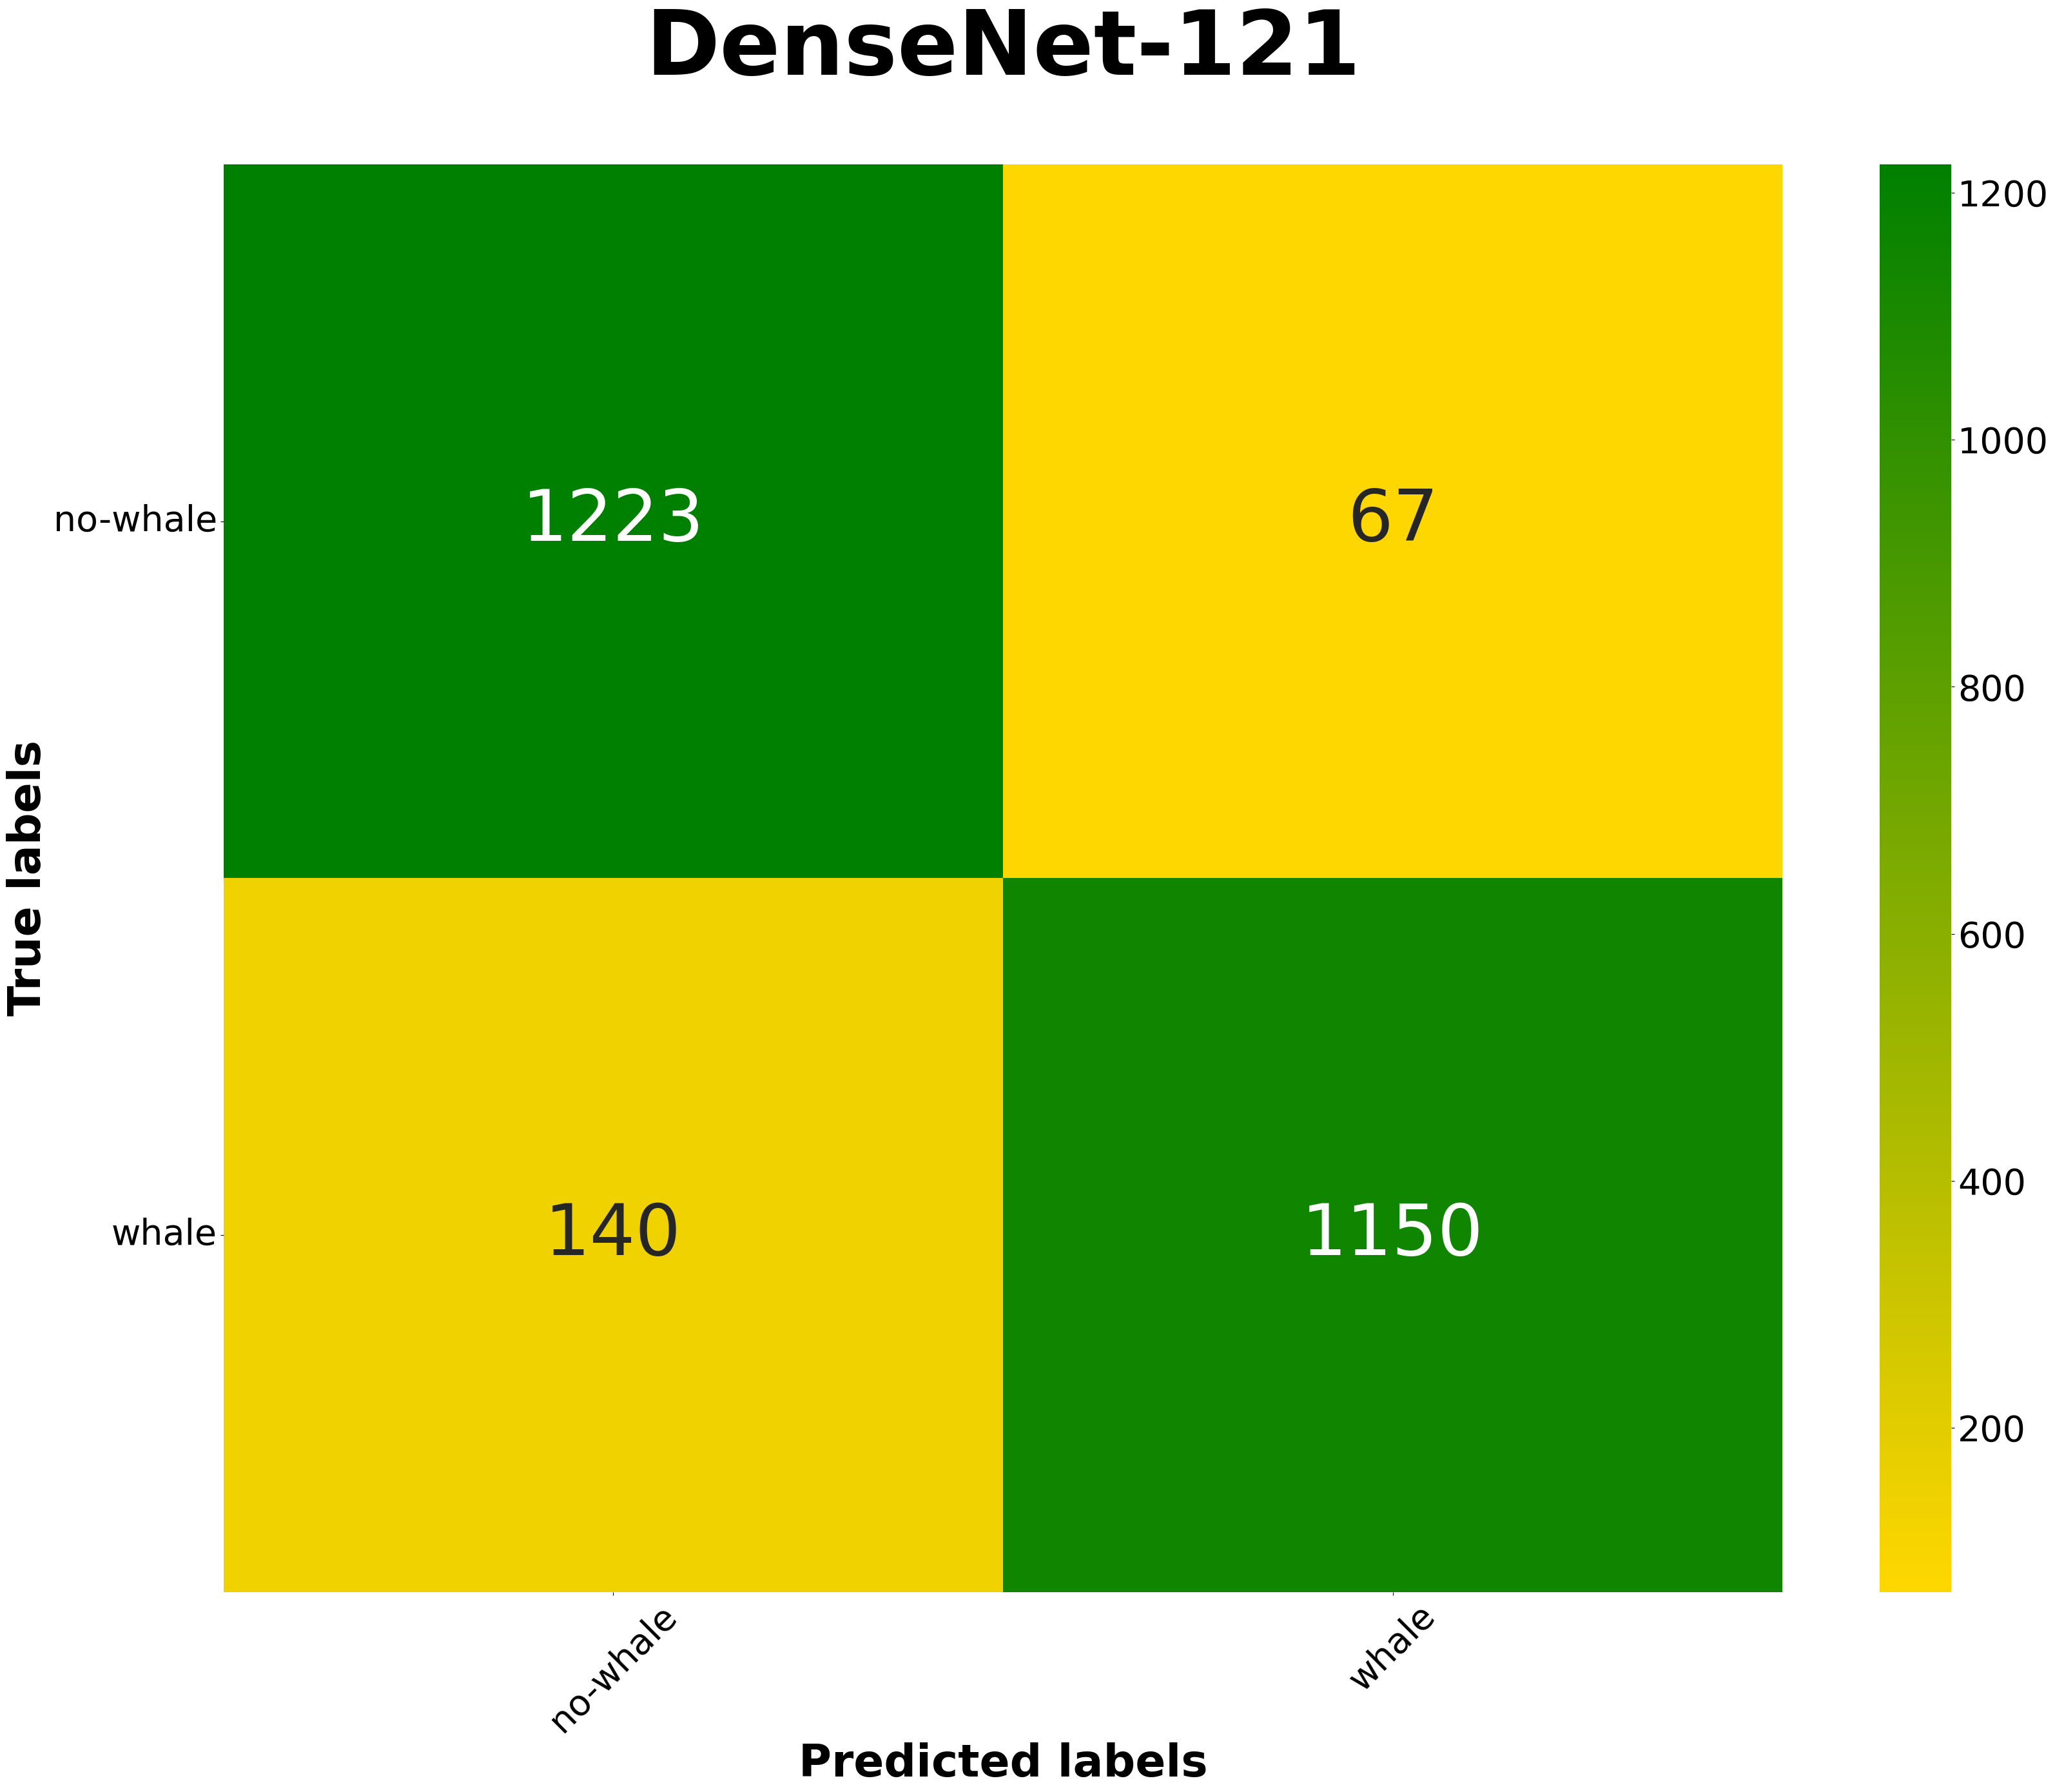

In [40]:
cm = confusion_matrix(y_true, y_preds, labels=list(range(len(target_names))))

SMALL_SIZE = 80
MEDIUM_SIZE = 40
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=0)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=0)  # legend fontsize
plt.rc('figure', titlesize=0)  # fontsize of the figure title

# Create a custom colormap from gold to green
gold_green_cmap = LinearSegmentedColormap.from_list("gold_green", ["gold", "green"])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(36,30))
sns.heatmap(cm, annot=True, fmt='g', cmap=gold_green_cmap, ax=ax)  # Use the custom colormap

# Set axis labels and titles with bold weight and adjusted fontsize
ax.set_xlabel('Predicted labels', weight="bold", fontsize=50)
ax.set_ylabel('True labels', weight="bold", fontsize=50)
tick_marks_x = np.arange(len(target_names)) + 0.5
tick_marks_y = np.arange(len(target_names)) + 0.5

# Set tick labels
plt.xticks(tick_marks_x, target_names, rotation=45, fontsize=40)
plt.yticks(tick_marks_y, target_names, rotation=0, fontsize=40)

# Set plot title
plt.title(f"DenseNet-121",fontsize=100,weight="bold",pad=100)
plt.tight_layout()  # Adjust layout to have space between the title and the figure

# Display the plot
plt.show()

# Save the figure
fig.savefig('cm_densenet_aug.svg', format='svg')

## Accuracies among the 5 models

In [41]:
final_results = {"train_losses":[],
                 "train_accuracies":[],
                 "valid_losses":[],
                 "valid_accuracies":[],
                 "test_losses":[],
                 "test_accuracies":[],
                 "test_recalls":[]}

In [42]:
for ind in range(5):
    model = Densenet121()
    state_dict = torch.load(f"{BEST_MODEL_FILENAME}_{ind}.pt")
    model.load_state_dict(state_dict)
    model.to(device)
    train_loss, train_acc = evaluate(model, train_loader, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    final_results["train_losses"].append(train_loss)
    final_results["train_accuracies"].append(train_acc)
    
    final_results["valid_losses"].append(valid_loss)
    final_results["valid_accuracies"].append(valid_acc)
    
    final_results["test_losses"].append(test_loss)
    final_results["test_accuracies"].append(test_acc)

    y_preds = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            y_true.append(y.view(-1,1))

            x = x.to(device)
            y = y.to(device)
                
            y_pred = model(x)
            
            top_pred = (torch.sigmoid(y_pred) > 0.5).int()
            y_preds.append(top_pred.detach().cpu().view(-1,1))

        y_preds = torch.cat(y_preds)
        y_true = torch.cat(y_true)
    test_recall = recall_score(y_true,y_preds)
    
    final_results["test_recalls"].append(test_recall)
    
    print(f'Model {ind} | Train Loss: {train_loss:.3f} -  Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} - Valid Acc: {valid_acc*100:.2f}% | Test Loss: {test_loss:.3f} - Test Acc: {test_acc*100:.2f}% \t')

Model 0 | Train Loss: 0.158 -  Train Acc: 93.11% | Valid Loss: 0.207 - Valid Acc: 92.13% | Test Loss: 0.199 - Test Acc: 91.43% 	
Model 1 | Train Loss: 0.120 -  Train Acc: 95.23% | Valid Loss: 0.200 - Valid Acc: 92.13% | Test Loss: 0.198 - Test Acc: 92.33% 	
Model 2 | Train Loss: 0.030 -  Train Acc: 99.16% | Valid Loss: 0.255 - Valid Acc: 92.21% | Test Loss: 0.260 - Test Acc: 91.82% 	
Model 3 | Train Loss: 0.114 -  Train Acc: 95.19% | Valid Loss: 0.209 - Valid Acc: 92.09% | Test Loss: 0.196 - Test Acc: 91.90% 	
Model 4 | Train Loss: 0.127 -  Train Acc: 94.73% | Valid Loss: 0.209 - Valid Acc: 92.25% | Test Loss: 0.201 - Test Acc: 91.98% 	


In [43]:
print(f"Mean test accuracy: {np.mean(final_results['test_accuracies']):.4f}")
print(f"Mean test recall: {np.mean(final_results['test_recalls']):.4f}")

Mean test accuracy: 0.9189
Mean test recall: 0.9084


In [44]:
final_results["test_recalls"]

[0.9162790697674419,
 0.9147286821705426,
 0.9093023255813953,
 0.9100775193798449,
 0.8914728682170543]